In [10]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import sklearn
import shap
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
import sys; sys.path.insert(0, '../src/') 
import necsuf_tabular_text as nec_suf
import cum_shp_plot
import anchors_comp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# !python3 -m pip install alibi==0.9.5

In [12]:
# dataset version taken from https://www.kaggle.com/kabure/german-credit-data-with-risk?select=german_credit_data.csv
german_cred_df = pd.read_csv("../datasets/german_credit_data.csv")

In [13]:
# following standard pre-processing from https://www.kaggle.com/vigneshj6/german-credit-data-analysis-python
german_cred_df['Saving accounts'] = german_cred_df['Saving accounts'].map({"little":0,"moderate":1,"quite rich":2 ,"rich":3 });
german_cred_df['Saving accounts'] = german_cred_df['Saving accounts'].fillna(german_cred_df['Saving accounts'].dropna().mean())

german_cred_df['Checking account'] = german_cred_df['Checking account'].map({"little":0,"moderate":1,"rich":2 });
german_cred_df['Checking account'] = german_cred_df['Checking account'].fillna(german_cred_df['Checking account'].dropna().mean())

german_cred_df['Sex'] = german_cred_df['Sex'].map({"male":0,"female":1}).astype(float);

german_cred_df['Housing'] = german_cred_df['Housing'].map({"own":0,"free":1,"rent":2}).astype(float);

german_cred_df['Purpose'] = german_cred_df['Purpose'].map({'radio/TV':0, 'education':1, 'furniture/equipment':2, 'car':3, 'business':4,
       'domestic appliances':5, 'repairs':6, 'vacation/others':7}).astype(float);

german_cred_df['Risk'] = german_cred_df['Risk'].map({"good":1,"bad":0}).astype(float);
german_cred_df.rename(columns={"Risk": "outcome"}, inplace=True)

german_cred_df.drop("Unnamed: 0", axis=1, inplace=True)
german_cred_df.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,outcome
0,67,0.0,2,0.0,0.456548,0.000000,1169,6,0.0,1.0
1,22,1.0,2,0.0,0.000000,1.000000,5951,48,0.0,0.0
2,49,0.0,1,0.0,0.000000,0.651815,2096,12,1.0,1.0
3,45,0.0,2,1.0,0.000000,0.000000,7882,42,2.0,1.0
4,53,0.0,2,1.0,0.000000,0.000000,4870,24,3.0,0.0
5,35,0.0,1,1.0,0.456548,0.651815,9055,36,1.0,1.0
6,53,0.0,2,0.0,2.000000,0.651815,2835,24,2.0,1.0
7,35,0.0,3,2.0,0.000000,1.000000,6948,36,3.0,1.0
8,61,0.0,1,0.0,3.000000,0.651815,3059,12,0.0,1.0
9,28,0.0,3,0.0,0.000000,1.000000,5234,30,3.0,0.0


### Problem intiailization

In [14]:
inp = pd.DataFrame(german_cred_df.iloc[998]).T
inp

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,outcome
998,23.0,0.0,2.0,1.0,0.0,0.0,1845.0,45.0,0.0,0.0


In [15]:
### ratio positive labels in dataset?
np.sum(german_cred_df.outcome)/len(german_cred_df)

0.7

In [16]:
#### Create F model
X,y = np.array(german_cred_df.iloc[:, :-1]), np.array(german_cred_df.iloc[:, -1:]).ravel()

X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(X, y, test_size=.2, random_state=42)

clf = ExtraTreesClassifier(random_state=0, max_depth=15)
clf.fit(X_train, y_train)
# save F(inp) for later
f_inp = clf.predict(np.array(inp.iloc[:, :-1]))
f_inp

array([0.])

In [17]:
german_cred_df['Model_pred'] = clf.predict(german_cred_df.iloc[:, :-1].values)

In [18]:
accuracy_score(y_test, clf.predict(X_test))

0.695

Tests of dataset: accuracy of single features

### CF 1: everyone from opposite class

In [19]:
num_features = len(inp.columns[:-1])
CF1_r2i, CF1_i2r, refs1 = \
    nec_suf.suff_nec_pipeline((german_cred_df.outcome != inp.outcome.item()), inp, clf, german_cred_df, num_features, predict=True)

In [20]:
print("##################")
print("Sufficiency R2I")
print("##################")
CF1_df_deg_r2i = nec_suf.deg_nec_suff(CF1_r2i, inp, f_inp, clf, num_features, r2i=True, pred_on_fly=False, deg_thresh=0)
sub_df_filtered = nec_suf.filter_by_degree_and_overalp(CF1_df_deg_r2i, degree_thresh=0.9, subset_max_num=10)
print("------------------")
print("necessity score: ", nec_suf.recall_nec_score(CF1_r2i, sub_df_filtered, f_inp))
print("------------------")
sub_df_filtered

##################
Sufficiency R2I
##################
------------------
necessity score:  0.29546127024094776
------------------


,subset,degree,string,cardinality,cost
226,"[2, 3, 5, 7]",0.924286,"Job 2.0, Housing 1.0, Checking accoun...",4,4.901544
177,"[0, 4, 5, 7]",0.964286,"Age 23.0, Saving accounts 0.0, Checking ...",4,5.198419
373,"[2, 4, 5, 7, 8]",0.918571,"Job 2.0, Saving accounts 0.0, Checking ...",5,5.503938
171,"[0, 3, 5, 7]",0.942857,"Age 23.0, Housing 1.0, Checking accoun...",4,5.552430
460,"[2, 3, 4, 5, 6, 8]",0.950000,"Job 2.0, Housing 1.0, Saving accounts ...",6,5.631867
376,"[3, 4, 5, 6, 7]",0.937143,"Housing 1.0, Saving accounts 0.0, Checking...",5,6.435617


In [21]:
print("##################")
print("Sufficiency I2R")
print("##################")

CF1_df_deg_i2r = nec_suf.deg_nec_suff(CF1_i2r, inp, f_inp, clf, num_features, r2i=False, deg_thresh=0)
sub_df_filtered_i2r = nec_suf.filter_by_degree_and_overalp(CF1_df_deg_i2r, degree_thresh=0.9, subset_max_num=10)
print("------------------")
print("necessity score: ", nec_suf.recall_nec_score(CF1_i2r, sub_df_filtered_i2r, f_inp, r2i=False))
print("------------------")
sub_df_filtered_i2r

##################
Sufficiency I2R
##################
------------------
necessity score:  0.14059955170690017
------------------


,subset,degree,string,cardinality,cost
378,"[3, 4, 5, 7, 8]",0.917143,"Housing 1.0, Saving accounts 0.0, Checki...",5,1.250000
439,"[1, 2, 3, 4, 5, 7]",0.902857,"Sex 0.0, Job 2.0, Housing 1.0...",6,1.553630
296,"[0, 2, 3, 5, 7]",0.904286,"Age 22.0, Job 2.0, Housing 1.0, C...",5,1.826923
312,"[0, 3, 4, 5, 7]",0.915714,"Age 22.0, Housing 1.0, Saving accounts...",5,1.826923
319,"[0, 3, 5, 7, 8]",0.915714,"Age 31.0, Housing 1.0, Checking acco...",5,2.669015
498,"[1, 2, 3, 5, 6, 7, 8]",0.902857,"Sex 0.0, Job 2.0, Housing 0.0, Chec...",7,2.829127
408,"[0, 1, 3, 5, 6, 7]",0.912857,"Age 24.0, Sex 0.0, Housing 0.0, C...",6,2.910755


### Precision/Recall curve

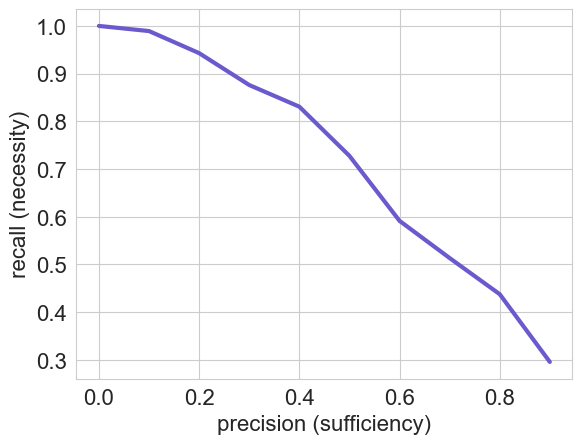

In [22]:
threshs, recalls_suff = nec_suf.prec_recall_curve(CF1_r2i, CF1_df_deg_r2i, f_inp)
threshs, recall_butfor = nec_suf.prec_recall_curve(CF1_i2r, CF1_df_deg_i2r, f_inp)
nec_suf.plot_prec_recall(threshs, recalls_suff, r2i=True)

### SHAP comparison

AttributeError: 'Index' object has no attribute '_format_native_types'

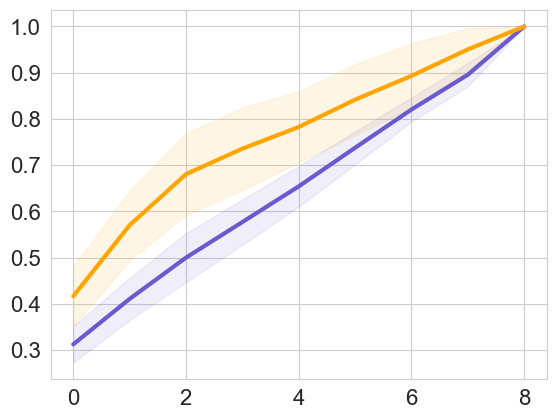

In [23]:
all_inp_deg_suff_r2i, all_inp_deg_suff_i2r, all_shaps = \
    cum_shp_plot.cumul_shap_vs_us_multi_input(german_cred_df, clf, 
                                              "dataset.outcome != inp_i.outcome.item()", num_features, num_inp=50)
cum_shp_plot.mean_and_plot(all_inp_deg_suff_r2i, all_shaps, title_name='sufficiency r2i')
cum_shp_plot.mean_and_plot(all_inp_deg_suff_i2r, all_shaps, title_name='sufficiency i2r')

### Create Facet figure for paper, german credit and spam vs. SHAP
**note, this requires running the SHAP comparison cells in Spam_experiment.ipynb. Only once results are stored in out/, can the next cells run properly**

In [ ]:
credit_r2i = pd.read_csv("out/credit_sufficiency_r2i_k_cum_shap_vs_us.csv")
credit_r2i['source'] = ['R2I']*len(credit_r2i)
credit_r2i['dataset'] = ['Credit']*len(credit_r2i)
credit_i2r = pd.read_csv("out/credit_sufficiency_i2r_k_cum_shap_vs_us.csv")
credit_i2r['source'] = ['I2R']*len(credit_i2r)
credit_i2r['dataset'] = ['Credit']*len(credit_i2r)
spam_r2i = pd.read_csv("out/spam_sufficiency_r2i_k_cum_shap_vs_us.csv")
spam_r2i['source'] = ['R2I']*len(spam_r2i)
spam_r2i['dataset'] = ['Spam']*len(spam_r2i)
spam_i2r = pd.read_csv("out/spam_sufficiency_i2r_k_cum_shap_vs_us.csv")
spam_i2r['source'] = ['I2R']*len(spam_i2r)
spam_i2r['dataset'] = ['Spam']*len(spam_i2r)

combined = pd.concat([credit_r2i, 
                      credit_i2r, 
                      spam_r2i, 
                      spam_i2r], axis=0)
combined_r2i = pd.concat([credit_r2i, spam_r2i], axis=0)
combined_i2r = pd.concat([credit_i2r, spam_i2r], axis=0)

combined_r2i["Unnamed: 0"] = combined_r2i["Unnamed: 0"].apply(lambda x: x+1)
combined_r2i = combined_r2i.rename(columns={"Unnamed: 0": "Cardinality"})

combined_i2r["Unnamed: 0"] = combined_i2r["Unnamed: 0"].apply(lambda x: x+1)
combined_i2r = combined_i2r.rename(columns={"Unnamed: 0": "Cardinality"})

In [ ]:
combined_r2i["ci_pos_shaps"] = combined_r2i["final_shaps_mean"]+combined_r2i["final_shaps_ci"]
combined_r2i["ci_neg_shaps"] = combined_r2i["final_shaps_mean"]-combined_r2i["final_shaps_ci"]
combined_r2i["ci_pos_ours"] = combined_r2i["our_k_inputs_mean"]+combined_r2i["our_k_inputs_ci"]
combined_r2i["ci_neg_ours"] = combined_r2i["our_k_inputs_mean"]-combined_r2i["our_k_inputs_ci"]

combined_i2r["ci_pos_shaps"] = combined_i2r["final_shaps_mean"]+combined_i2r["final_shaps_ci"]
combined_i2r["ci_neg_shaps"] = combined_i2r["final_shaps_mean"]-combined_i2r["final_shaps_ci"]
combined_i2r["ci_pos_ours"] = combined_i2r["our_k_inputs_mean"]+combined_i2r["our_k_inputs_ci"]
combined_i2r["ci_neg_ours"] = combined_i2r["our_k_inputs_mean"]-combined_i2r["our_k_inputs_ci"]

In [ ]:
sns.set_style("whitegrid")
BIGGER_SIZE = 16
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

g = sns.FacetGrid(combined_r2i, col="dataset")

g.map(plt.plot, "Cardinality", "final_shaps_mean", color='slateblue', linewidth=3, label='SHAP')
g.map(plt.fill_between, "Cardinality", "ci_neg_shaps", "ci_pos_shaps", color='slateblue', alpha=0.3)
g.map(plt.plot, "Cardinality", "our_k_inputs_mean", color='orange', linewidth=3, label=r'$\bf{LENS}$')
g.map(plt.fill_between, "Cardinality", "ci_neg_ours", "ci_pos_ours", color='orange', alpha=0.3)
g.set(ylabel="Degree")
for ax in g.axes.flat:
    if ax.get_title():
        ax.set_title(" ".join([x.split("=")[1] for x in ax.get_title().split('|')]),fontweight="bold")
    if ax.texts:
        ax.texts[0].remove()
        
    # Make x and y-axis labels slightly larger
    ax.set_xlabel(ax.get_xlabel())
    ax.set_xticks(list(range(1,10)))

        
g.add_legend()
plt.savefig("out/credit_spam_shap_r2i.png", dpi=200, bbox_inches='tight')
plt.show()


In [ ]:
sns.set_style("whitegrid")
BIGGER_SIZE = 16
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

g = sns.FacetGrid(combined_i2r, col="dataset")

g.map(plt.plot, "Cardinality", "final_shaps_mean", color='slateblue', linewidth=3, label='SHAP')
g.map(plt.fill_between, "Cardinality", "ci_neg_shaps", "ci_pos_shaps", color='slateblue', alpha=0.3)
g.map(plt.plot, "Cardinality", "our_k_inputs_mean", color='orange', linewidth=3, label=r'$\bf{LENS}$')
g.map(plt.fill_between, "Cardinality", "ci_neg_ours", "ci_pos_ours", color='orange', alpha=0.3)
g.set(ylabel="Degree")
for ax in g.axes.flat:
    if ax.get_title():
        ax.set_title(" ".join([x.split("=")[1] for x in ax.get_title().split('|')]),fontweight="bold")
    if ax.texts:
        ax.texts[0].remove()
    ax.set_xlabel(ax.get_xlabel())
    ax.set_xticks(list(range(1,10)))

        
g.add_legend()
plt.savefig("out/credit_spam_shap_i2r.png", dpi=200, bbox_inches='tight')
plt.show()


### Anchors comparison

In [ ]:
num_inp = 100
deg_thresh = 0.9
all_inp_deg, anchors_df = anchors_comp.anchors_card_prec_comp(german_cred_df, clf, num_features,
                       "dataset.outcome != inp_i.outcome.item()", num_inp=num_inp, deg_thresh=deg_thresh)

In [ ]:
anchors_comp.plt_degree_anchors_comp(all_inp_deg, anchors_df, num_inp, type='min', shape='boxplot', tau=deg_thresh)

In [ ]:
anchors_comp.plt_degree_anchors_comp(all_inp_deg, anchors_df, num_inp, type='mean', shape='boxplot', tau=deg_thresh)

In [ ]:
anchors_comp.plt_degree_anchors_comp(all_inp_deg, anchors_df, num_inp, type='max', shape='boxplot', tau=deg_thresh)